# Benchmark Nengo Models

This notebook runs a collection of different models using `nengo_loihi`, and compares the resultling behaviour to that of the same model running in Nengo.  These benchmarks were created before we started development of `nengo_loihi`, and are meant to exercise some of the more complex structures that we used in developing Spaun.

To run these benchmarks, you will require:

 - https://github.com/tcstewar/pytry   
 - https://github.com/nengo/nengo-benchmarks
 - https://pandas.pydata.org/
 
To install these, do the following:
```
git clone https://github.com/tcstewar/pytry
pip install -e pytry
https://github.com/nengo/nengo-benchmarks
pip install -e nengo-benchmarks
pip install pandas
```

Each of the benchmarks consist of:
 - a set of parameters to adjust the benchmark
 - a Nengo model created based on those parameters
 - a plot showing the qualitative performance of the model
 - a set of quantitative measures from running the model
 
For this notebook, we adjust some of the benchmark parameters.  The main reason is to reduce some of the models to be small enough to fit on a single Loihi chip.  We also adjust dt for accuracy reasons.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengo_benchmarks
import nengo_loihi
import pandas

For each of these benchmarks, we will run the model in mutliple conditions.  Here is our list of conditions:

In [2]:
conditions = [
    'nengo',                                         # the normal nengo backend
    'nengo_loihi(precompute=False, target="sim", remove_passthrough=True)',   # using the nengo_loihi simulator
    #'nengo_loihi(precompute=False, target="loihi", remove_passthrough=True)', # using Loihi itself
]

This script will run a given benchmark using the provided arguments in all the conditions requested, showing the plots and returning a pandas.DataFrame with the quantitative results.

In [3]:
import traceback
def test(name, kwargs):
    trial = getattr(nengo_benchmarks, name)()
    
    params = []
    for name, desc in trial.param_descriptions.items():
        if name in trial.system_params:
            continue
        if name in ['backend', 'neuron_type']:
            continue
        value = kwargs.get(name, trial.param_defaults[name])
        params.append((name, value, desc))
    for name, value, desc in sorted(params):
        print("  %15s = %-10r (%s)" % (name, value, desc))
     
    results = []
    for i, condition in enumerate(conditions):
        plt.figure(figsize=(12,3))
        try:
            r = trial.run(backend=condition, plt=plt, verbose=False, **kwargs)
        except Exception as e:
            traceback.print_exc()
            r = {}            
        r['condition'] = condition
        results.append(r)
        print("Plot for %s:" % condition)
        plt.show()
    return pandas.DataFrame(results)

## Communication Channel

We start with a very simple model: A chain of Ensembles which are just passing their input to their output.  We feed in a 2-dimensional value to the first Ensemble, and it does an identity function decode to the next, and that one to the next, and so on.  The ideal output is the same as the input, and we compute the RMS error.

                D = 2          (number of dimensions)
                L = 2          (number of layers)
                N = 100        (number of neurons per layer)
                T = 1.0        (simulation time)
               dt = 0.0001     (nengo timestep)
             pstc = 0.01       (synaptic time constant)
             seed = 1          (random number seed)
          weights = False      (use full weight matrices)
Plot for nengo:


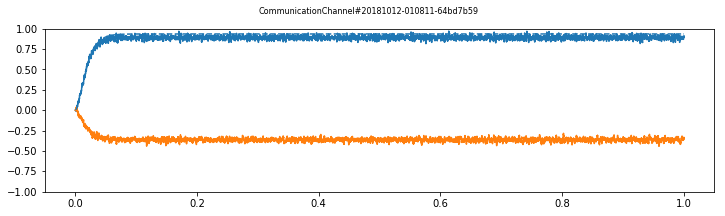

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


Plot for nengo_loihi(precompute=False, target="sim", remove_passthrough=True):


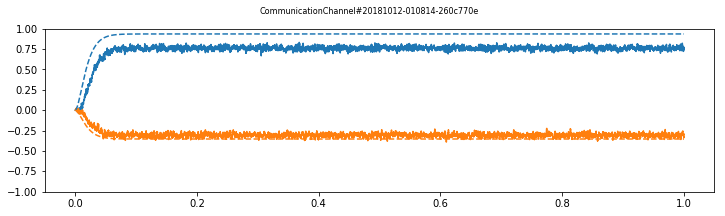

,condition,rmse,speed
0,nengo,0.038049,0.392860
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.132959,0.245702


In [4]:
test('CommunicationChannel', dict(dt=0.0001))

## Circular Convolution

Next we have Circular Convolution.  Two randomly chosen D-dimensional vectors are the input, and the output should be the circular convolution of the two.  We use this operation extensively in our large-scale cognitive models (such as Spaun), and it requires very dense connectivity, making it well-suited for stressing the routing of information between neurons.

We restrict this to 4 dimensions to allow it to fit on one Loihi core.  In Spaun, we use 512 dimensions.

                D = 4          (dimensionality)
               SD = 8          (subdimensions)
                T = 0.5        (time to run simulation)
               dt = 0.0001     (nengo timestep)
          n_cconv = 200        (neurons per cconv)
          n_per_d = 50         (neurons per dimension I/O)
             pstc = 0.01       (post-synaptic time constant)
             seed = 1          (random number seed)
Plot for nengo:


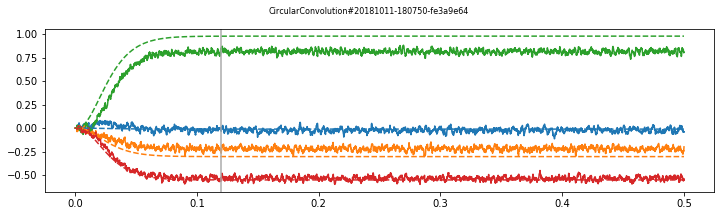

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)


Plot for nengo_loihi(precompute=False, target="sim"):


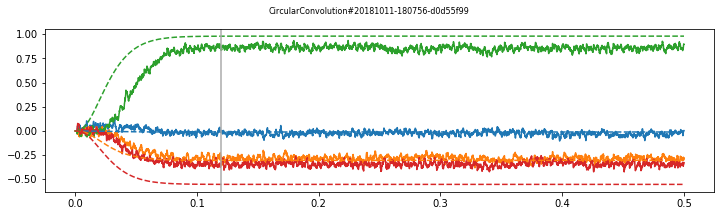

,condition,rmse,speed
0,nengo,0.095372,0.091489
1,"nengo_loihi(precompute=False, target=""sim"")",0.124568,0.022056


In [9]:
test('CircularConvolution', dict(dt=0.0001, D=4))

## Inhibition

This is a simple test that ensures that having one group of neurons inhibit another works, and is scaled correctly.  This is needed to many congnitive control tasks.  The Ensemble being inhibited as an initial value of 1, and the amount of inhibition should linearly increase until that Ensemble is completely suppressed (and thus represents 0).

                D = 1          (number of dimensions)
                T = 3.0        (time to run)
               dt = 0.001      (nengo timestep)
     inh_strength = 2.0        (inhibition strength)
        n_neurons = 100        (number of neurons)
             seed = 1          (random number seed)
Plot for nengo:


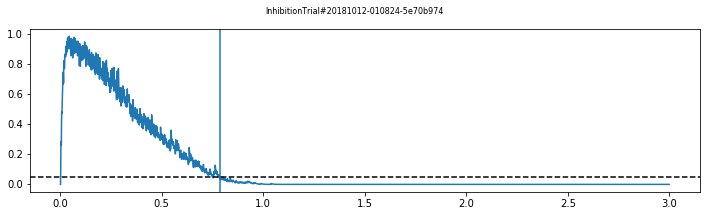

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_cx.py:184: UserWarning: Cannot change tau_s on already configured neurons
  "Cannot change tau_s on already configured neurons")


Plot for nengo_loihi(precompute=False, target="sim", remove_passthrough=True):


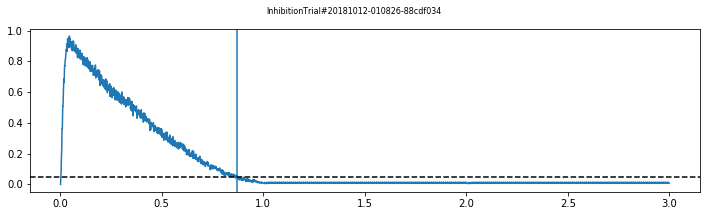

,condition,speed,time_to_inhibit
0,nengo,2.340114,0.789
1,"nengo_loihi(precompute=False, target=""sim"", re...",1.903275,0.871


In [5]:
test('InhibitionTrial', dict(dt=0.001))

## Learning Speedup

This is a self-supervised learning benchmark where the system tries to learn to predict its own output.  However, halfway through the benchmark, the mapping from input to output is changed, and so it now needs to learn this new mapping.  This is a simplified version of the model presented in http://compneuro.uwaterloo.ca/publications/aubin2016a.html as a model of the development of learning addition facts.

One slight oddity about this benchmark is that the Loihi performance matches the normal nengo performance better with a learning rate that is 10% smaller than the nengo one.  To demonstrate this, we run the benchmark twice with different learning rates.

                D = 1          (dimensionality)
                T = 40.0       (time to simulate for)
               dt = 0.0001     (nengo timestep)
       learn_rate = 0.0001     (learning rate)
        n_neurons = 100        (number of neurons)
       n_switches = 2          (number of time to change function)
             seed = 1          (random number seed)
         tau_fast = 0.01       (fast path time constant)
         tau_slow = 0.2        (slow path time constant)
Plot for nengo:


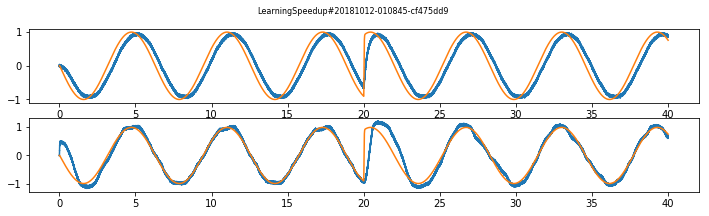

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_cx.py:505: UserWarning: Overflow in V
  warnings.warn(msg)


Plot for nengo_loihi(precompute=False, target="sim", remove_passthrough=True):


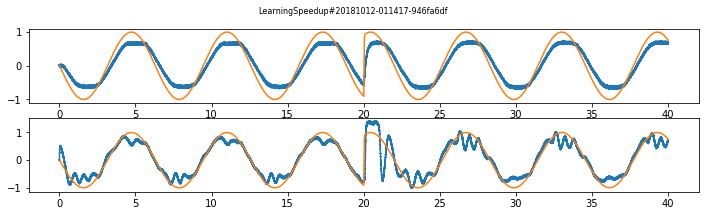

,condition,rmse,speed
0,nengo,0.226242,0.122927
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.244852,0.062271


In [6]:
test('LearningSpeedup', dict(dt=0.0001, learn_rate=1e-4))

                D = 1          (dimensionality)
                T = 40.0       (time to simulate for)
               dt = 0.0001     (nengo timestep)
       learn_rate = 1e-05      (learning rate)
        n_neurons = 100        (number of neurons)
       n_switches = 2          (number of time to change function)
             seed = 1          (random number seed)
         tau_fast = 0.01       (fast path time constant)
         tau_slow = 0.2        (slow path time constant)
Plot for nengo:


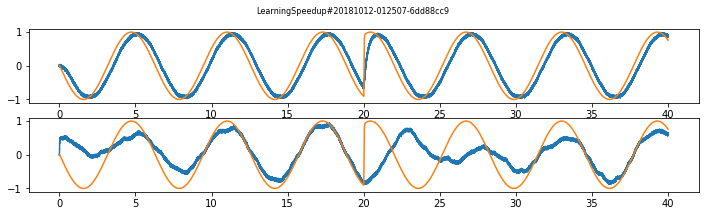

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_cx.py:505: UserWarning: Overflow in V
  warnings.warn(msg)


Plot for nengo_loihi(precompute=False, target="sim", remove_passthrough=True):


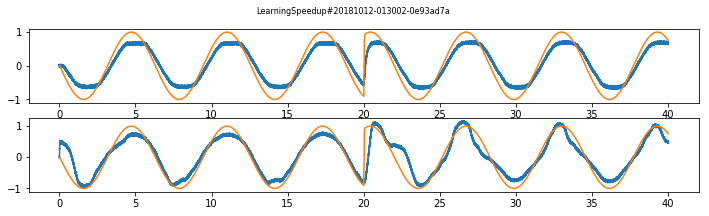

,condition,rmse,speed
0,nengo,0.579088,0.138286
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.267779,0.060632


In [7]:
test('LearningSpeedup', dict(dt=0.0001, learn_rate=1e-5))

## Lorenz Attractor

As a test of implementing arbitrary dynamical systems, we implement the chaotic Lorenz attractor.  This has no input at all and should produce a chaotic pattern.

                N = 330        (number of neurons)
                T = 10.0       (time to run simulation)
             beta = 2.6666666666666665 (Lorenz variable)
               dt = 0.001      (nengo timestep)
              rho = 28.0       (Lorenz variable)
             seed = 1          (random number seed)
            sigma = 10.0       (Lorenz variable)
              tau = 0.1        (post-synaptic time constant)
Plot for nengo:


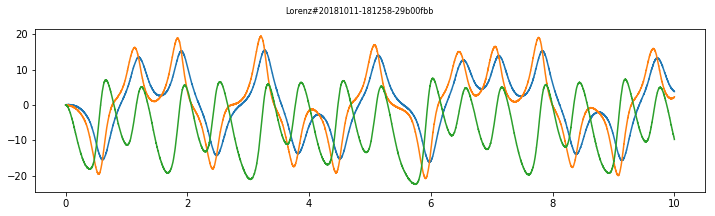

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 2 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


Plot for nengo_loihi(precompute=False, target="sim"):


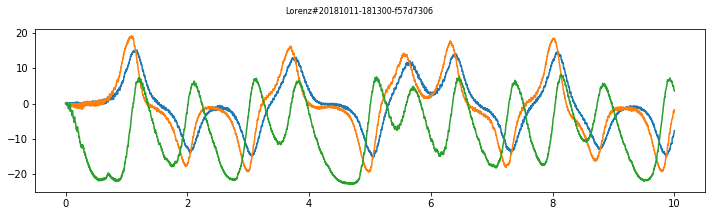

,condition,mean,speed,std
0,nengo,-1.719092,7.880769,8.779023
1,"nengo_loihi(precompute=False, target=""sim"")",-3.294929,1.586574,8.484621


In [13]:
test('Lorenz', dict(dt=0.001, N=330))

## Matrix Multiplication

Here we build a model that can multiply any given two matrices together (of dimensions D1xD2 and D2xD3).

               D1 = 1          (size of matrices)
               D2 = 2          (size of matrices)
               D3 = 2          (size of matrices)
                N = 50         (number of neurons for input&output)
           N_mult = 200        (number of neurons for pairwise multiply)
                T = 0.5        (time to run simulation)
               dt = 0.0001     (nengo timestep)
             pstc = 0.01       (post-synaptic time constant)
           radius = 1          (range of values)
             seed = 5          (random number seed)
Plot for nengo:


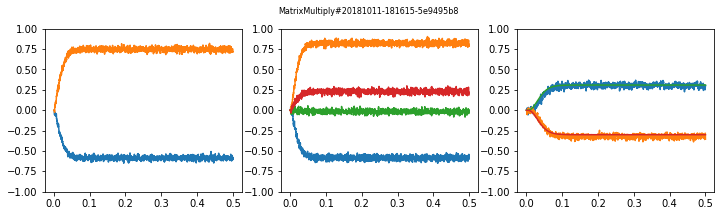

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


Plot for nengo_loihi(precompute=False, target="sim"):


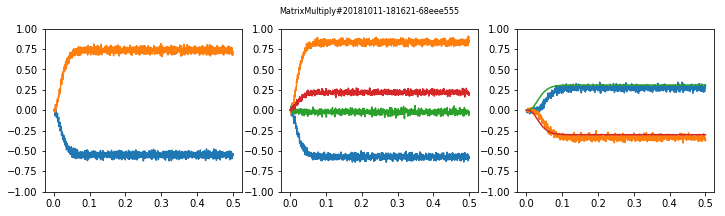

,condition,rmse,speed
0,nengo,0.027519,0.108887
1,"nengo_loihi(precompute=False, target=""sim"")",0.049321,0.045817


In [16]:
test('MatrixMultiply', dict(dt=0.0001, seed=5))

## SPA Sequence

Here we implement the model of the cortex-basal ganglia-thalamus loop described in http://compneuro.uwaterloo.ca/publications/stewart2010a.html and which we have used as the basis of cognitive control for Spaun and a variety of other models.  In this case, we configure it to go through a sequence of states.  If the cortex is in state A, then the basal ganglia and thalamus drive the cortex towards state B.  If it is in B, it will be driven towards C, and so on.


                D = 8          (dimensionality)
                T = 4          (time to simulate)
               dt = 0.0005     (nengo timestep)
        n_actions = 3          (number of actions)
             seed = 1          (random number seed)
Plot for nengo:


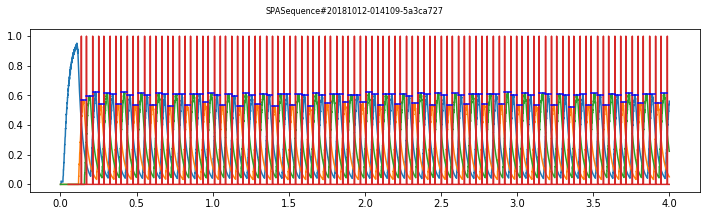

c:\users\terry\documents\github\nengo-loihi\nengo_loihi\builder.py:257: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 3 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_api.py:450: UserWarning: Lost 2 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
c:\users\terry\documents\github\nengo-loihi\nengo_loihi\loihi_cx.py:505: UserWarning: Overflow in V
  warnings.warn(msg)


Plot for nengo_loihi(precompute=False, target="sim", remove_passthrough=True):


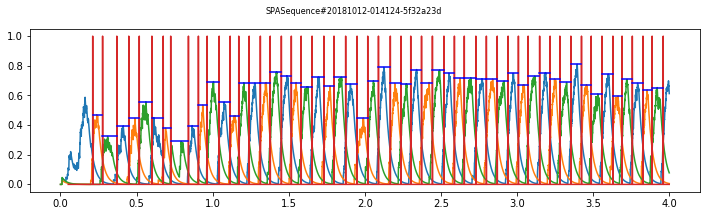

,condition,peak,peak_sd,period,period_sd,speed
0,nengo,0.586236,0.033228,0.038119,0.002968,0.285617
1,"nengo_loihi(precompute=False, target=""sim"", re...",0.639297,0.126892,0.070726,0.009395,0.106236


In [8]:
test('SPASequence', dict(dt=0.0005, n_actions=3, D=8, T=4))

In [ ]:
test('SemanticMemory', dict(dt=0.0001, D=4))

In [ ]:
test('SemanticMemoryWithRecall', dict(dt=0.0001, D=8))

In [ ]:
test('MNIST', dict(n_neurons=60, dt=0.001))

In [ ]:
test('Oscillator', dict(dt=0.01))

In [ ]:
test('Parsing', dict(dt=0.0005, D=8))

In [ ]:
test('SPASequenceRouted', dict(dt=0.0005, n_actions=5, D=8, T=4))

In [ ]:
test('ConvolutionCleanup', dict(dt=0.0001, D=2))